In [1]:
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from joblib import dump
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#### Fungsi untuk ekstraksi fitur GLCM

In [2]:
def extract_glcms_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray_image, distances=[1], angles=[135], levels=256, symmetric=True, normed=True)
    properties = ['contrast', 'homogeneity', 'energy', 'correlation']
    glcm_features = [graycoprops(glcm, prop).ravel()[0] for prop in properties]
    return glcm_features

#### Fungsi untuk ekstraksi fitur HSV

In [3]:
def extract_hsv_features(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) #Opencv defaultnya is BGR
    h, s, v = cv2.split(hsv_image)
    hsv_features = [np.mean(h), np.mean(s), np.mean(v)]
    return hsv_features

#### Path ke folder dataset

In [4]:
dataset_paths = {
    'aeromonas': 'LibraryDataset/Training/Aeromonas',
    'penyakit_lain': 'LibraryDataset/Training/Penyakit_Lain/',
    'sehat': 'LibraryDataset/Training/Sehat'
}

#### Memuat dataset

In [5]:
X = []
y = []

#### Buat loop untuk memasukkan gambar ke array X dan label ke array Y

In [6]:
for label, path in dataset_paths.items():
    for file_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, file_name)) 
        glcm_features = extract_glcms_features(image)
        hsv_features = extract_hsv_features(image)
        features = glcm_features + hsv_features
        X.append(features) #Array X = 0 , X = []
        y.append(label)

In [7]:
# Split dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [8]:
# Membuat dan melatih model KNN
knn_model = KNeighborsClassifier()

In [9]:
# Menyetel hyperparameter KNN menggunakan GridSearchCV
param_grid = {
    'n_neighbors': [3, 4, 5, 6, 7, 8, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
grid_search = GridSearchCV(knn_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9],
                         'weights': ['uniform', 'distance']})

In [10]:
# Mendapatkan model terbaik setelah penyetelan
best_knn_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:")
print(best_params)

Best Parameters:
{'algorithm': 'auto', 'n_neighbors': 4, 'weights': 'distance'}


In [11]:
# Evaluasi model terbaik
y_pred = best_knn_model.predict(X_test)

In [12]:
# Simpan model terbaik
model_path = 'best_knn_model.h5'
dump(best_knn_model, model_path)

['best_knn_model.h5']

In [13]:
# Buat confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

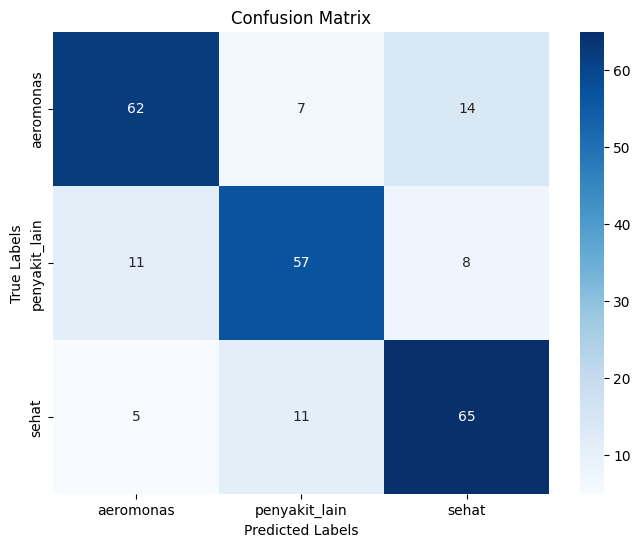

In [14]:
# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y)), yticklabels=sorted(set(y)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Hitung True Positives, True Negatives, False Positives, dan False Negatives
TP = np.diag(conf_matrix).sum()
TN = np.sum(conf_matrix) - (np.sum(conf_matrix, axis=0) - np.diag(conf_matrix)).sum()
FP = np.sum(conf_matrix, axis=0) - np.diag(conf_matrix)
FN = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)

# Hitung akurasi
accuracy = (TP + TN) / (TP + TN + FP.sum() + FN.sum())
print("Accuracy:", accuracy)

Accuracy: 0.7666666666666667


In [16]:
# Buat DataFrame dari fitur dan label
data = {'Fitur': X}
df = pd.DataFrame(data)

In [17]:
#Pisahkan fitur GLCM dan HSV
df['GLCM_Contrast'] = [feat[0] for feat in df['Fitur']]
df['GLCM_Homogeneity'] = [feat[1] for feat in df['Fitur']]
df['GLCM_Energy'] = [feat[2] for feat in df['Fitur']]
df['GLCM_Correlation'] = [feat[3] for feat in df['Fitur']]
df['HSV_H_Mean'] = [feat[4] for feat in df['Fitur']]
df['HSV_S_Mean'] = [feat[5] for feat in df['Fitur']]
df['HSV_V_Mean'] = [feat[6] for feat in df['Fitur']]

In [18]:
# Hapus kolom 'Fitur' yang tidak diperlukan
df = df.drop('Fitur', axis=1)

In [19]:
# Simpan DataFrame ke file CSV
df.to_csv('ekstraksi_fitur_training.csv', index=False)